In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Standardize data. This can be done by subtracting the mean and dividing by the standard deviation for each value of each variable
#Reason for this is PCA is sensitive to large intial changes. We need to do this to remove potential bias.

df = pd.read_csv('https://raw.githubusercontent.com/dymarczykm1/dymarczykm1/main/Data/InterestRatesNew.csv')

#Setting the date as the index
df.set_index('Date',inplace=True)

#Converting the index as date
df.index = pd.to_datetime(df.index)

#Standardize the data in the df into z scores
df_std = ((df-df.mean()) / df.std())
df_std.head()

,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,,,
2015-01-02,-0.943399,-0.925617,-0.86527,-0.592926,-0.281192,0.076069,0.191291,0.246021,0.176977,0.301522
2015-01-05,-0.931801,-0.937092,-0.85378,-0.568947,-0.293738,0.021919,0.090190,0.123911,0.014653,0.138809
2015-01-06,-0.931801,-0.937092,-0.86527,-0.604916,-0.343923,-0.072844,-0.010911,0.017064,-0.111599,-0.005825
2015-01-07,-0.931801,-0.948566,-0.86527,-0.640885,-0.369015,-0.113457,-0.039797,0.001800,-0.111599,-0.005825
2015-01-08,-0.931801,-0.960041,-0.88825,-0.640885,-0.369015,-0.072844,0.032418,0.108647,0.032689,0.120730


In [3]:
#Creating a covariance matrix 
corr_matrix_array = np.array(np.cov(df_std, rowvar=False))

In [4]:
#Perform eigen decomposition
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix_array)

#Put data into a DataFrame and save to excel
df_eigval = pd.DataFrame({"Eigenvalues":eigenvalues}, index=range(1,11))

df_eigval.to_excel(r"C:\Users\dymar\OneDrive\Desktop\2021-VOR-Model\data\df_eigenval.xlsx")
eigenvalues

array([8.57592301e+00, 1.33172222e+00, 6.56407298e-02, 1.90284762e-02,
       4.49930419e-03, 1.73522322e-03, 6.29630776e-04, 4.36407572e-04,
       2.44980017e-04, 1.40025117e-04])

In [5]:
# Save output to Excel - [0] is the equivalent to df.head() for an array
df_eigvec = pd.DataFrame(eigenvectors, index=range(1,11))

df_eigvec.to_excel(r"C:\Users\dymar\OneDrive\Desktop\2021-VOR-Model\data\df_eigenvec.xlsx")
eigenvectors[0]

array([ 0.29201843,  0.43794367, -0.39547439, -0.31565119, -0.43850875,
       -0.27983142, -0.36194239,  0.24466468,  0.06684791, -0.03110652])

In [6]:
# Work out explained proportion 
df_eigval["Explained proportion"] = df_eigval["Eigenvalues"] / np.sum(df_eigval["Eigenvalues"])

#Format as percentage
df_eigval.style.format({"Explained proportion": "{:.2%}"})

,Eigenvalues,Explained proportion
1,8.575923,85.76%
2,1.331722,13.32%
3,0.065641,0.66%
4,0.019028,0.19%
5,0.004499,0.04%
6,0.001735,0.02%
7,0.000630,0.01%
8,0.000436,0.00%
9,0.000245,0.00%
10,0.000140,0.00%


In [7]:
principal_components = df_std.dot(eigenvectors)
principal_components.head()

,0,1,2,3,4,5,6,7,8,9
Date,,,,,,,,,,
2015-01-02,-0.812890,-1.529410,0.329987,-0.048670,-0.193787,0.026970,-0.020638,-0.014371,-0.033413,0.007599
2015-01-05,-0.992204,-1.321525,0.400720,-0.021330,-0.185260,0.009892,-0.036108,-0.002779,-0.027486,0.018843
2015-01-06,-1.203963,-1.159735,0.410870,-0.025891,-0.174791,0.014068,-0.039366,-0.010394,-0.031335,0.010576
2015-01-07,-1.255961,-1.158937,0.371201,-0.029447,-0.165342,0.016887,-0.042702,-0.001432,-0.043540,-0.001405
2015-01-08,-1.114960,-1.335424,0.313261,-0.062557,-0.163139,0.012567,-0.053947,-0.009125,-0.036185,0.004084


In [8]:
# Calaculate 10YR-6Mo Slope and also curve flex
df_s = pd.DataFrame(data=df)
df_s = df_s[['10 Yr', '5 Yr', '6 Mo']]
df_s["Slope"] = df_s['10 Yr'] - df_s['6 Mo']
df_s["Flex"] = df_s['10 Yr'] + df_s['6 Mo'] - 2 * df_s['5 Yr']
df_s.head()

,10 Yr,5 Yr,6 Mo,Slope,Flex
Date,,,,,
2015-01-02,2.12,1.61,0.11,2.01,-0.99
2015-01-05,2.04,1.57,0.10,1.94,-1.00
2015-01-06,1.97,1.50,0.10,1.87,-0.93
2015-01-07,1.96,1.47,0.09,1.87,-0.89
2015-01-08,2.03,1.50,0.08,1.95,-0.89


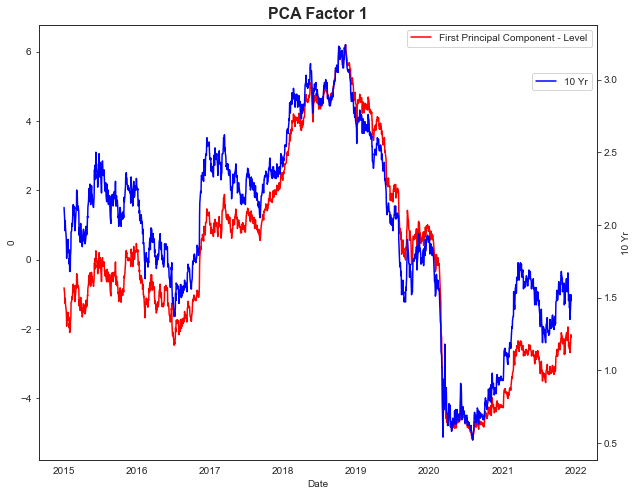

In [9]:
#First eigenvector has all components positive (parallel level shift), 
#the second eigenvector has the first half of the components positive and the second half negative (slope tilt), 
#the third eigenvector has the first third of the components positive, second third negative, and the last third positive (flex),
sns.set_style('white') # setting style
plt.subplots(figsize=(10, 8)) # setting figure size
sns.lineplot(data=principal_components[0], label='First Principal Component - Level', color="r")
ax2 = plt.twinx()
sns.lineplot(data=df['10 Yr'], label='10 Yr', color="b", ax=ax2)
plt.title('PCA Factor 1', fontsize=16, fontweight='bold')
plt.legend(bbox_to_anchor=(1.0, 0.9))
plt.show()

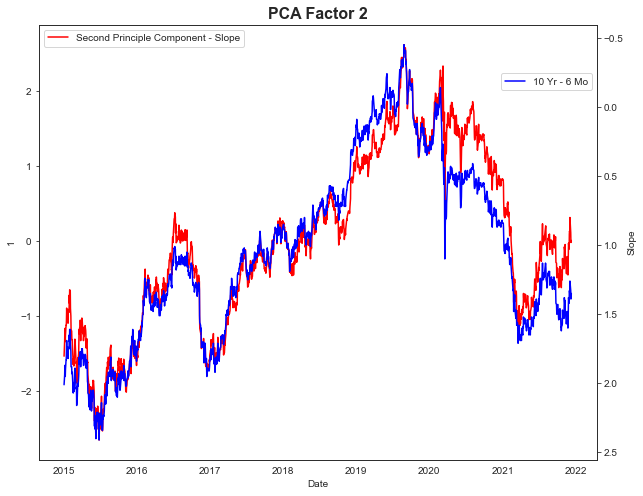

In [10]:
sns.set_style('white') # setting style
plt.subplots(figsize=(10, 8)) # setting figure size
sns.lineplot(data=principal_components[1], label='Second Principle Component - Slope', color="r")
ax2 = plt.twinx()
sns.lineplot(data=df_s['Slope'], label='10 Yr - 6 Mo', color="b", ax=ax2)
plt.gca().invert_yaxis()
plt.title('PCA Factor 2', fontsize=16, fontweight='bold')
plt.legend(bbox_to_anchor=(1.0, 0.9))
plt.show()

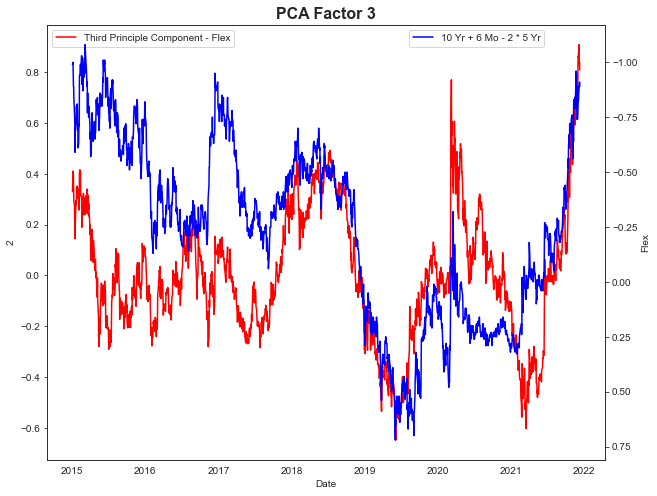

In [11]:
sns.set_style('white') # setting style
plt.subplots(figsize=(10, 8)) # setting figure size
sns.lineplot(data=principal_components[2], label='Third Principle Component - Flex', color="r")
ax2 = plt.twinx()
sns.lineplot(data=df_s['Flex'], label='10 Yr + 6 Mo - 2 * 5 Yr', color="b", ax=ax2)
plt.gca().invert_yaxis()
plt.title('PCA Factor 3', fontsize=16, fontweight='bold') 
plt.legend(bbox_to_anchor=(1.0, 0.5, -0.1, 0.5))
plt.show()